In [1]:
import tensorflow as tf
import numpy as np
import models
import sampling
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
NUM_EPOCHS = 30
BATCH_SIZE = 32
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])

#Use 20% of data for initial global model
sample = sampling.Distribution("CIFAR10", 5)
m = models.CIFAR10_CNN()

dict_users = sample.iid()
indices = list(dict_users[0])
train_samples, train_labels = sample.train_data
train_samples, train_lables = train_samples[indices], train_labels[indices]
test_samples, test_labels = sample.test_data

train_ds = tf.data.Dataset.from_tensor_slices((train_samples, train_lables))
train_ds = train_ds.batch(BATCH_SIZE)

2023-05-30 14:51:32.946684: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2023-05-30 14:51:34.978478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 14:51:38.083585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22309 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-05-30 14:51:38.084474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22309 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-05-30 14:51:38.085046: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localho

In [2]:
for i in range(NUM_EPOCHS):
  for x, y in train_ds:
    result = m.train(x, y)

  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"Loss: {losses[i]:.3f}")

# Save the trained weights to a checkpoint.
m.save('/home/ubuntu/21thinh.dd/FedMobile/checkpoints/model.ckpt')


/home/ubuntu/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2023-05-30 14:51:50.347561: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-05-30 14:51:51.445838: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-30 14:51:51.446247: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-30 14:51:51.446262: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-30 14:51:51.446889: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn 

Finished 10 epochs
Loss: 0.875
Finished 20 epochs
Loss: 0.081
Finished 30 epochs
Loss: 0.006


{'checkpoint_path': <tf.Tensor: shape=(), dtype=string, numpy=b'/home/ubuntu/21thinh.dd/FedMobile/checkpoints/model.ckpt'>}

In [3]:
m.evaluate(test_samples, test_labels)

2023-05-30 14:52:57.978727: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


<tf.Tensor: shape=(), dtype=float32, numpy=0.5537>

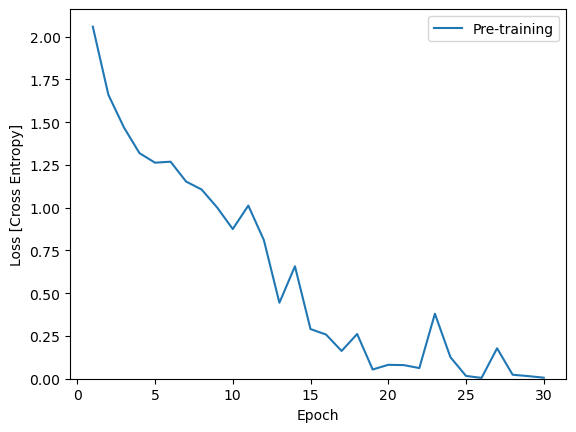

In [4]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend()

In [6]:
import tempfile
import os
dir = '/home/ubuntu/21thinh.dd/FedMobile/tflite'
SAVED_MODEL_DIR = os.path.join(dir, "CNN_CIFAR10/1/")
tf.saved_model.save(m.model, SAVED_MODEL_DIR)

INFO:tensorflow:Assets written to: /home/ubuntu/21thinh.dd/FedMobile/tflite/CNN_CIFAR10/1/assets


INFO:tensorflow:Assets written to: /home/ubuntu/21thinh.dd/FedMobile/tflite/CNN_CIFAR10/1/assets


In [16]:
SAVED_MODEL_DIR = "/home/ubuntu/21thinh.dd/FedMobile/tflite/CNN_CIFAR10"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
        'evaluate':
            m.evaluate.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

ValueError: Expected an object of type `Trackable`, such as `tf.Module` or a subclass of the `Trackable` class, for export. Got <models.CIFAR10_CNN object at 0x7ff7017b3eb0> with type <class 'models.CIFAR10_CNN'>.

InvalidArgumentError: Input to reshape is a tensor with 3072 values, but the requested shape has 1024 [Op:Reshape]

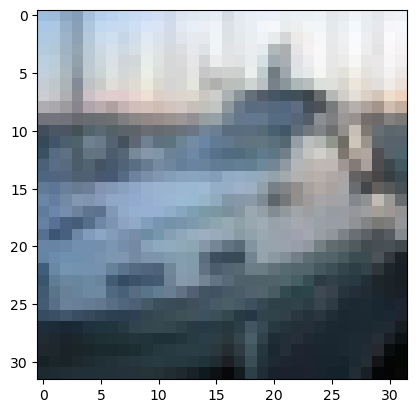

In [13]:
plt.imshow(test_samples[2])
test = tf.reshape(test_samples[2], [1,32,32])
probabilities = tf.nn.softmax(m.infer(test)['logits'], axis=-1)
print(probabilities)